In [1]:
import os 
import pickle
import hashlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
from sklearn.metrics import accuracy_score
import seaborn as sns 

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Softmax
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy 
from tensorflow.keras.models import load_model

2024-10-18 16:42:07.667543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 16:42:08.689057: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-18 16:42:08.902588: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-18 16:42:08.902604: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

## Load Data

#### Impoartant! 
Download the dataset locally from [OneDrive here](https://purdue0-my.sharepoint.com/personal/du245_purdue_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdu245%5Fpurdue%5Fedu%2FDocuments%2FShared%2FQSC%20ML%20for%20readout%2FFinal%5Fraw%5Fdata%5Ffor%5Fpaper%2Fdata%5F0528%5Fnpy). We are using QICK data with timestamp **0528**. 

In [2]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [3]:
train_data_dir = "../data/malab_05282024/npz/"
test_data_dir = "../data/malab_05282024/npz/"
start_window = 0
end_window = 770

In [4]:
"""Loadning training split"""
x_train_path = os.path.join(train_data_dir, f'0528_X_train_0_770.npy')
y_train_path = os.path.join(train_data_dir, f'0528_y_train_0_770.npy')

assert os.path.exists(x_train_path), f"ERROR: File {x_train_path} does not exist."
assert os.path.exists(y_train_path), f"ERROR: File {y_train_path} does not exist."

X_train_val = np.load(x_train_path)
y_train_val = np.load(y_train_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_train_val).hexdigest() == 'b61226c86b7dee0201a9158455e08ffb',  "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_train_val).hexdigest() == 'c59ce37dc7c73d2d546e7ea180fa8d31',  "Checksum failed. Wrong file was loaded or file may be corrupted."

# Get readout window
X_train_val = X_train_val[:,start_window*2:end_window*2]
# y_train_val = one_hot_encode(y_train_val)
assert len(X_train_val[0]) == (end_window-start_window)*2, f"ERROR: X_test sample size {len(X_train_val[0])} does not match (start window, end window) ({start_window},{end_window}) size."


print("Train Data Set:")
print(f"  X Path : {x_train_path}")
print(f"  y Path : {y_train_path}")
print(f"  Size : {len(X_train_val):,}")
print(f"  Shape : {X_train_val[0].shape}")

Train Data Set:
  X Path : ../data/malab_05282024/npz/0528_X_train_0_770.npy
  y Path : ../data/malab_05282024/npz/0528_y_train_0_770.npy
  Size : 900,000
  Shape : (1540,)


In [5]:
"""Loading testing split"""
x_test_path = os.path.join(test_data_dir, f'0528_X_test_0_770.npy')
y_test_path = os.path.join(test_data_dir, f'0528_y_test_0_770.npy')

assert os.path.exists(x_test_path), f"ERROR: File {x_test_path} does not exist."
assert os.path.exists(y_test_path), f"ERROR: File {y_test_path} does not exist."

X_test = np.load(x_test_path)
y_test = np.load(y_test_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_test).hexdigest() == 'b7d85f42522a0a57e877422bc5947cde', "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_test).hexdigest() == '8c9cce1821372380371ade5f0ccfd4a2', "Checksum failed. Wrong file was loaded or file may be corrupted."

# Get readout window
X_test = X_test[:,start_window*2:end_window*2]
# y_test = one_hot_encode(y_test)
assert len(X_test[0]) == (end_window-start_window)*2, f"ERROR: X_test sample size {len(X_test[0])} does not match (start window, end window) ({start_window},{end_window}) size."


print("Test Data Set:")
print(f"  X Path : {x_test_path}")
print(f"  y Path : {y_test_path}")
print(f"  Size : {len(X_test):,}" )
print(f"  Sample Shape : {X_test[0].shape}")

Test Data Set:
  X Path : ../data/malab_05282024/npz/0528_X_test_0_770.npy
  y Path : ../data/malab_05282024/npz/0528_y_test_0_770.npy
  Size : 100,000
  Sample Shape : (1540,)


## Build our Model 
Architecture: input_shape -> 14 -> 2 (output)

In [ ]:
def get_model_800x4x1(input_shape):
    model = Sequential()
    model.add(Dense(4, activation=None, name='fc1',input_shape=(input_shape,)))
    model.add(BatchNormalization(name='batchnorm1'))
    model.add(Dense(1, activation='sigmoid',name='fc2'))
    return model

def get_model_800xhnx2(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='relu'))
    return model

input_shape = int((end_window-start_window)*2)
model = get_model_800x4x1(input_shape=input_shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 4)                 6164      
                                                                 
 batchnorm1 (BatchNormalizat  (None, 4)                16        
 ion)                                                            
                                                                 
 fc2 (Dense)                 (None, 1)                 5         
                                                                 
Total params: 6,185
Trainable params: 6,177
Non-trainable params: 8
_________________________________________________________________
None


2024-10-18 16:43:01.953039: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-10-18 16:43:01.960394: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-18 16:43:01.960406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator7.fnal.gov): /proc/driver/nvidia/version does not exist
2024-10-18 16:43:01.970154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Scan Window Location and Size

In [7]:
"""hyperparameters"""
init_learning_rate = 1e-3
validation_split = 0.05  # 45,000 sample size 
batch_size = 256
epochs = 150
early_stopping_patience = 15
checkpoint_filename = "multi-layer-hidden.h5"
checkpoint_dir = '../checkpoints/scan_window_location_and_size_h4'

assert os.path.exists(checkpoint_dir), f'ERROR: Checkpoint directory {checkpoint_dir} does not exist.'

# scan parameters 
all_window_start_locations = list(range(0, 351, 50))
all_window_sizes = list(range(50, 701, 50)) + [770]

print('Scanning window start locations:', all_window_start_locations)
print('Total locations:', len(all_window_start_locations))
print('Scanning window sizes:', all_window_sizes)
print('Total window sizes:', len(all_window_sizes))

Scanning window start locations: [0, 50, 100, 150, 200, 250, 300, 350]
Total locations: 8
Scanning window sizes: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 770]
Total window sizes: 15


In [8]:
all_e_accuracy = list() 
all_g_accuracy = list()
all_accuracy = np.zeros([len(all_window_sizes), len(all_window_start_locations)])
all_fidelity = np.zeros([len(all_window_sizes), len(all_window_start_locations)])

# 64 total runs 
for idx, window_size in enumerate(all_window_sizes):
    X_train_val = np.load(x_train_path)  # need to load data again to avoid memory issues 
    X_test = np.load(x_test_path)
    for jdx, start_location in enumerate(all_window_start_locations):
        #########################
        # 0. prep data 
        #########################
        # check if window size is too big for start location
        if start_location+window_size > 770:
            all_fidelity[idx, jdx] = np.nan
            print(f'Skipping start location={start_location}, window size={window_size}')
            continue
        X_train_val_window = X_train_val[:,start_location*2:(start_location+window_size)*2]
        X_test_window = X_test[:,start_location*2:(start_location+window_size)*2]

        #########################
        # 1. init callbacks
        #########################
        ckp_dir = os.path.join(checkpoint_dir, f'sl{start_location}_ws{window_size}')
        if os.path.exists(ckp_dir) == False: os.mkdir(ckp_dir)
        ckp_filename = os.path.join(ckp_dir, checkpoint_filename)
        callbacks = [
            ModelCheckpoint(
                ckp_filename,
                monitor="val_loss",
                verbose=0,
                save_best_only=True,
                save_weights_only=False,
                save_freq="epoch",
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=early_stopping_patience,
                restore_best_weights=True,
            ),
        ]

        #########################
        # 2. declare model 
        #########################
        opt = Adam(learning_rate=init_learning_rate)
        model = get_model_800x4x1(input_shape=window_size*2)
        model.compile(
            optimizer=opt, 
            loss=BinaryCrossentropy(from_logits=False), 
            metrics=['accuracy']
        )

        #########################
        # 3. train 
        #########################
        history = model.fit(
            X_train_val_window, 
            y_train_val, 
            batch_size=batch_size,
            epochs=epochs, 
            validation_split=validation_split, 
            shuffle=True, 
            callbacks=callbacks,
            verbose=0,
        )

        # Save the history dictionary
        with open(os.path.join(ckp_dir, 'training_history.pkl'), 'wb') as f:
            pickle.dump(history.history, f)

        # load best checkpoint point 
        model = load_model(ckp_filename)

        #########################
        # 4. compute fidelity 
        #########################
        y_pred = model.predict(X_test_window)
        test_acc = accuracy_score(y_test, np.where(y_pred < 0.5, 0, 1).reshape(-1))
        all_accuracy[idx, jdx] = test_acc
        all_fidelity[idx, jdx] = test_acc*2-1
        
        print('\n===================================')
        print(f'Start location = {start_location}, Window size = {window_size}')
        print('    Accuracy', test_acc)
        print('    Fidelity', test_acc*2-1)


3125/3125 [==============================] - 1s 214us/step

Start location = 0, Window size = 50
    Accuracy 0.54062
    Fidelity 0.08123999999999998
3125/3125 [==============================] - 1s 214us/step

Start location = 50, Window size = 50
    Accuracy 0.653
    Fidelity 0.30600000000000005
3125/3125 [==============================] - 1s 200us/step

Start location = 100, Window size = 50
    Accuracy 0.74812
    Fidelity 0.49624
3125/3125 [==============================] - 1s 206us/step

Start location = 150, Window size = 50
    Accuracy 0.7974
    Fidelity 0.5948
3125/3125 [==============================] - 1s 215us/step

Start location = 200, Window size = 50
    Accuracy 0.82301
    Fidelity 0.64602
3125/3125 [==============================] - 1s 224us/step

Start location = 250, Window size = 50
    Accuracy 0.82806
    Fidelity 0.65612
3125/3125 [==============================] - 1s 199us/step

Start location = 300, Window size = 50
    Accuracy 0.83188
    Fidelity 0.66

In [9]:
outfile = '_2-layer_scan_window_size_and_location_window_size_0_770.npz'
note = f'Training data on 0528, readout fidelity with 2-layer NN, scanned window size and location, model is 800x4x1'

np.savez(
    os.path.join(checkpoint_dir, outfile), 
    accuracy = np.array(all_accuracy), 
    fidelity = np.array(all_fidelity), 
    all_window_start_locations=np.array(all_window_start_locations),
    all_window_sizes=np.array(all_window_sizes),
    note=note
)

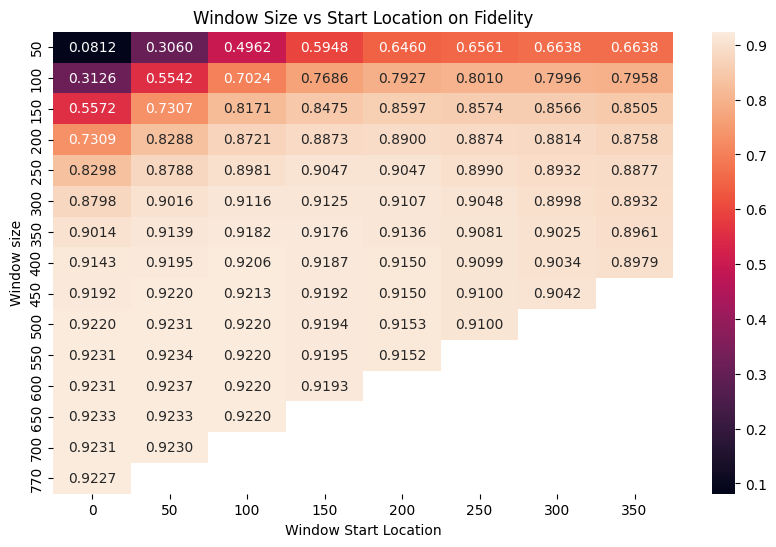

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(all_fidelity, annot=True, fmt='.4f', yticklabels=all_window_sizes, xticklabels=all_window_start_locations)
plt.title('Window Size vs Start Location on Fidelity')
plt.xlabel('Window Start Location')
plt.ylabel('Window size')
plt.savefig(os.path.join(checkpoint_dir, 'window_size_vs_start_770.png'))

### Combine all runs 

In [ ]:
data1 = np.load(os.path.join(checkpoint_dir, '_2-layer_scan_window_size_and_location.npz'))
data2 = np.load(os.path.join(checkpoint_dir, '_2-layer_scan_window_size_and_location_450_700.npz'))
data3 = np.load(os.path.join(checkpoint_dir, '_2-layer_scan_window_size_and_location_window_size_770.npz'))
data = np.concatenate((data1['fidelity'], data2['fidelity'], data3['fidelity']), 0)

In [ ]:
xi, yi = np.where(data > 0.92)
all_window_sizes = list(range(50, 701, 50)) + [770]

plt.figure(figsize=(10, 6))
ax = plt.gca()
sns.heatmap(data, annot=True, fmt='.4f', mask=np.isnan(data), yticklabels=all_window_sizes, xticklabels=all_window_start_locations)
for i in range(len(xi)):
    ax.add_patch(Rectangle((yi[i], xi[i]), 1, height=1, fill=False, edgecolor='red', lw=3))
plt.title('Window Size vs Start Location on Fidelity')
plt.xlabel('Window Start Location')
plt.ylabel('Window size')
plt.savefig(os.path.join(checkpoint_dir, 'window_size_vs_start_all.png'))